[[[1.  2.1]]

 [[1.5 1.6]]

 [[2.  1. ]]]


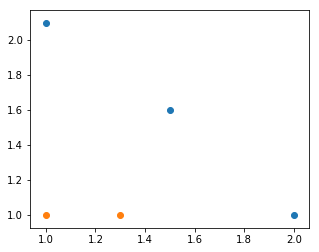

[[-0.69314718]
 [ 0.69314718]]
[[-1.66610226]
 [ 1.66610226]]
[[-2.56198199]
 [ 2.56198199]]
[[-1.]
 [ 1.]]


In [4]:
# -*-coding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt

"""
Author:
    Jack Cui
Blog:
    http://blog.csdn.net/c406495762
Zhihu:
    https://www.zhihu.com/people/Jack--Cui/
Modify:
    2017-10-10
"""

def loadSimpData():
    """
    创建单层决策树的数据集
    Parameters:
        无
    Returns:
        dataMat - 数据矩阵
        classLabels - 数据标签
    """
    datMat = np.matrix([[ 1. ,  2.1],
        [ 1.5,  1.6],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

def showDataSet(dataMat, labelMat):
    """
    数据可视化
    Parameters:
        dataMat - 数据矩阵
        labelMat - 数据标签
    Returns:
    无
    """
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)#转换为numpy矩阵
    print(data_plus_np)
    data_minus_np = np.array(data_minus)#转换为numpy矩阵
    plt.rcParams['figure.figsize']=(5.0,4.0)
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1])#正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1])#负样本散点图
    plt.show()

def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    """
    单层决策树分类函数
    Parameters:
        dataMatrix - 数据矩阵
        dimen - 第dimen列，也就是第几个特征
        threshVal - 阈值
        threshIneq - 标志
    Returns:
        retArray - 分类结果
    """
    retArray = np.ones((np.shape(dataMatrix)[0],1))#初始化retArray为1
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0#如果小于阈值,则赋值为-1
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0#如果大于阈值,则赋值为-1
    return retArray
    

def buildStump(dataArr,classLabels,D):
    """
    找到数据集上最佳的单层决策树
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        D - 样本权重
    Returns:
        bestStump - 最佳单层决策树信息
        minError - 最小误差
        bestClasEst - 最佳的分类结果
    """
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = float('inf')#最小误差初始化为正无穷大
    for i in range(n):#遍历所有特征
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()#找到特征中最小的值和最大值
        stepSize = (rangeMax - rangeMin) / numSteps#计算步长
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:#大于和小于的情况，均遍历。lt:less than，gt:greater than
                threshVal = (rangeMin + float(j) * stepSize)#计算阈值
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)#计算分类结果
                errArr = np.mat(np.ones((m,1)))#初始化误差矩阵
                errArr[predictedVals == labelMat] = 0#分类正确的,赋值为0
                weightedError = D.T * errArr#计算误差
                # print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:#找到误差最小的分类方式
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    """
    使用AdaBoost算法提升弱分类器性能
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        numIt - 最大迭代次数
    Returns:
        weakClassArr - 训练好的分类器
        aggClassEst - 类别估计累计值
    """
    weakClassArr = []
    m = np.shape(dataArr)[0]#行数
    D = np.mat(np.ones((m, 1)) / m)#初始化权重
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)#构建单层决策树
        # print("D:",D.T)
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))#计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
        bestStump['alpha'] = alpha#存储弱学习算法权重 
        weakClassArr.append(bestStump)#存储单层决策树
        # print("classEst: ", classEst.T)
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)#计算e的指数项
        D = np.multiply(D, np.exp(expon)) 
        D = D / D.sum()#根据样本权重公式，更新样本权重
        #计算AdaBoost误差，当误差为0的时候，退出循环
        aggClassEst += alpha * classEst#计算类别估计累计值
        # print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1))) 	#计算误差
        errorRate = aggErrors.sum() / m
        # print("total error: ", errorRate)
        if errorRate == 0.0: break#误差为0，退出循环
    return weakClassArr, aggClassEst


def adaClassify(datToClass,classifierArr):
    """
    AdaBoost分类函数
    Parameters:
        datToClass - 待分类样例
        classifierArr - 训练好的分类器
    Returns:
        分类结果
    """
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):#遍历所有分类器，进行分类
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        print(aggClassEst)
    return np.sign(aggClassEst)

if __name__ == '__main__':
    dataArr,classLabels = loadSimpData()
    showDataSet(dataArr,classLabels)
    weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, classLabels)
    print(adaClassify([[0,0],[5,5]], weakClassArr))